# Data Preparation

This notebook cleans and prepares the data for training, validation, and testing.

In [1]:
%matplotlib inline

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import pickle
import glob
import PIL

### Filter out filler pages

Remove filler pages that do not contain sheet music information (e.g. title, foreword).  The file filler.txt indicates which pages are filler.

In [3]:
def getFillerList(filler_file, feat_dir):
    d = {} # list of pages to remove
    with open(filler_file, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) > 1:
                relpath = parts[0] # e.g. Bach/00748
                scoreID = os.path.basename(relpath) # e.g. 00748
                removeField = parts[1].strip('"') # e.g. "0,1,-2,-1" or "r" or "rl"
                numPages = getNumPages(relpath, feat_dir)
                if removeField == 'r' or removeField == 'rl': # remove all pages
                    for pkl_file in glob.glob('{}/{}/*.pkl'.format(feat_dir, parts[0])):
                        pageID = os.path.splitext(os.path.basename(pkl_file))[0] # e.g. 00822-3
                        d[pageID] = 1
                else:
                    for pageNumStr in removeField.split(','):
                        pageNum = int(pageNumStr)
                        if pageNum < 0:
                            pageID = '{}-{}'.format(scoreID, numPages + pageNum)
                            d[pageID] = 1
                        else:
                            pageID = '{}-{}'.format(scoreID, pageNum)
                            d[pageID] = 1
    return d

In [4]:
def getNumPages(relpath, indir):
    numPages = len(glob.glob('{}/{}/*.pkl'.format(indir, relpath)))
    return numPages

In [52]:
def getNonFillerFeatures(filler_file, feat_dir):
    '''
    Collect bootleg score features from all pages that are (a) not filler and (b) have a valid 
    bootleg score matrix.
    '''
    
    filler = getFillerList(filler_file, feat_dir)
    feats = {}
    
    for pieceDir in glob.glob('{}/*/*/'.format(feat_dir)): # e.g. score_feat/Bach/00748/
        
        pieceID = pieceDir.split('/')[-2]
        composer = pieceDir.split('/')[-3]
        accum = [] # features from all pages in this score (or None if filler/no features extracted)
        numPages = len(glob.glob('{}/*.pkl'.format(pieceDir)))
        
        for i in range(numPages):
            
            pkl_file = '{}/{}-{}.pkl'.format(pieceDir, pieceID, i)
            pageID = '{}-{}'.format(pieceID, i) # e.g. 00748-2
            if pageID in filler: # filler page, skip
                accum.append(None)
                continue
            with open(pkl_file, 'rb') as f:
                bscore = pickle.load(f)['bscore']
            if bscore is None: # if None, no features were computed
                accum.append(None)
            else:
                accum.append(bscore == 1) # convert from float to bool to compress memory
        
        if len(accum) > 0:
            feats[pieceDir] = accum
    
    return feats

In [53]:
filler_file = 'cfg_files/filler.txt'
score_feat_dir = 'score_feat'
feats = getNonFillerFeatures(filler_file, score_feat_dir) # key: pieceDir, value: list of bscore feats for each page

### Investigate Feature Statistics

In [55]:
def getFeatureStats(feats):
    
    # count number of features per page
    featsPerPage = []
    for pieceDir in feats:
        for elem in feats[pieceDir]:
            if elem is not None:
                featsPerPage.append(elem.shape[1])
    featsPerPage = np.array(featsPerPage)
    printStats(featsPerPage, "Number of Features Per Page")
    
    # plot histogram
    plt.subplot(2,1,1)
    plt.hist(featsPerPage, bins=100)
    plt.xlabel('Number of Events In Single Page')
    plt.ylabel('Frequency')
    plt.show()
    
    # count total number of pages by composer
    pages = {}
    for pieceDir in feats: # e.g. score_feat/Bach/00748/
        composer = pieceDir.split('/')[-3]
        if composer not in pages:
            pages[composer] = 0
        pages[composer] += len([1 for elem in feats[pieceDir] if elem is not None])
    pageCnts = [pages[composer] for composer in pages]
    composers = [composer[0:5] for composer in pages]
    printStats(pageCnts, "Total Number of Pages by Composer")
    
    # plot histogram
    x_pos = np.arange(len(pageCnts))
    plt.bar(x_pos, pageCnts)
    plt.xticks(x_pos, composers)
    plt.ylabel('Total # Pages')
    plt.show()
    
    # count total number of note events by composer
    noteEvents = {}
    for pieceDir in feats: # e.g. score_feat/Bach/00748/
        composer = pieceDir.split('/')[-3]
        if composer not in noteEvents:
            noteEvents[composer] = 0
        for elem in feats[pieceDir]:
            if elem is not None:
                noteEvents[composer] += elem.shape[1]
    noteEventCnts = [noteEvents[composer] for composer in noteEvents]
    printStats(noteEventCnts, "Total Number of Note Events by Composer")
    
    # plot histogram
    x_pos = np.arange(len(composers))
    plt.bar(x_pos, noteEventCnts)
    plt.xticks(x_pos, composers)
    plt.ylabel('Total # Note Events')
    plt.show()
    
    return

In [56]:
def printStats(arr, title = None):
    if title:
        print(title)
    print('Mean: {}'.format(np.mean(arr)))
    print('Std: {}'.format(np.std(arr)))
    print('Min: {}'.format(np.min(arr)))
    print('Max: {}'.format(np.max(arr)))

Number of Features Per Page
Mean: 205.02559082645783
Std: 66.72883397647097
Min: 18
Max: 499


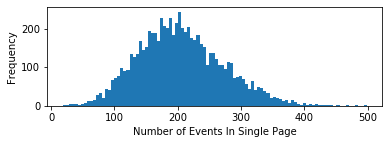

Total Number of Pages by Composer
Mean: 794.5555555555555
Std: 547.6182999764852
Min: 347
Max: 2272


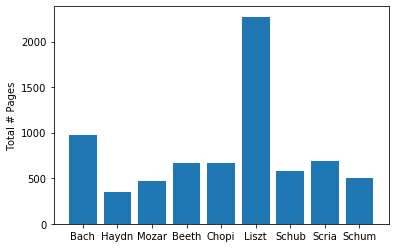

Total Number of Note Events by Composer
Mean: 162904.22222222222
Std: 92578.94143171699
Min: 87957
Max: 394088


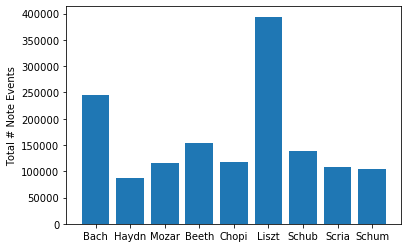

In [57]:
getFeatureStats(feats)

Note that there is a wide variation in the number of features per page and a significant class imbalance in the data.  We will define a proxy task which tries to classify short fixed-length chunks of bootleg score features, and resample the classes to ensure class balance.

### Split Data into Train, Validation, & Test

Below we separate the data into train, validation, & test sets.  We split the data by piece (as opposed to page) to ensure total separation.  This data corresponds to the original task of classifying a single page of sheet music.

In [58]:
def splitTrainValidTest(d, train=.6, validation=.2, test=.2, savefile = None):
    
    # shuffle
    assert(train + validation + test == 1.0)
    np.random.seed(0)
    pieceDirs = list(d.keys())
    np.random.shuffle(pieceDirs)
    
    # split
    breakpt1 = int(len(pieceDirs) * train)
    breakpt2 = breakpt1 + int(len(pieceDirs) * validation)
    pieceDirs_train = pieceDirs[0:breakpt1]
    pieceDirs_valid = pieceDirs[breakpt1:breakpt2]
    pieceDirs_test = pieceDirs[breakpt2:]
    
    # save
    d_train = getDataSubset(d, pieceDirs_train)
    d_valid = getDataSubset(d, pieceDirs_valid)
    d_test = getDataSubset(d, pieceDirs_test)
    if savefile:
        saveToPickle([d, pieceDirs_train, pieceDirs_valid, pieceDirs_test], savefile)
    
    return d_train, d_valid, d_test

In [59]:
def getDataSubset(dAll, toKeep):
    dSubset = {}
    for pieceDir in toKeep:
        dSubset[pieceDir] = dAll[pieceDir]
    return dSubset

In [60]:
def saveToPickle(d, outfile):
    with open(outfile, 'wb') as f:
        pickle.dump(d, f)

In [61]:
def loadPickle(infile):
    with open(infile, 'rb') as f:
        d = pickle.load(f)
    return d

In [62]:
save_pages_file = '{}/data.pages.pkl'.format(score_feat_dir)
d_train, d_valid, d_test = splitTrainValidTest(feats, train=.6, validation=.2, test=.2, savefile=save_pages_file)

### Format data in chunks

Below we prepare the data for the proxy task, which assumes a fixed-length (L=64) chunk of bootleg features.  To ensure class balance, we randomly sample the same number of chunks from each class.

In [74]:
def getComposer2IndexMapping(feat_dir):
    composers = []
    for composerDir in sorted(glob.glob('{}/*/'.format(feat_dir))):
        composer = composerDir.split('/')[-2]
        composers.append(composer)
    c_to_i = {c:i for i, c in enumerate(composers)}
    
    return c_to_i, composers

In [75]:
def getChunkedData_uniformSampling(d, chunkSize, c_to_i):
    '''
    Uniform sampling with 50% overlap.  Doesn't keep page location info.
    '''
    frags = []
    labels = []
    pieceDir2idxRange = {}
    for pieceDir in d:
        merged = np.hstack(d[pieceDir])
        composerIdx = c_to_i[pieceDir.split('/')[-3]]
        startChunkIdx = len(frags)
        for startIdx in range(0, merged.shape[1], chunkSize // 2):
            endIdx = startIdx + chunkSize
            if endIdx <= merged.shape[1]:
                frags.append(merged[:,startIdx:endIdx])
                labels.append(composerIdx)
        endChunkIdx = len(frags)
        pieceDir2idxRange[pieceDir] = (startChunkIdx, endChunkIdx)
    frags = np.array(frags)
    labels = np.array(labels)
    
    return frags, labels, pieceDir2idxRange

In [76]:
def getChunkedData_balanced(d, chunkSize, samplesPerComposer, composers):
    '''
    Samples the same number of windows from each composer to avoid class imbalance.
    Also keeps the page location for debugging and error analysis.
    '''
    np.random.seed(0)
    
    frags = []
    labels = []
    pagelocs = [] # list of (pieceDir, startPage, endPage) tuples
    
    for composerIdx, composer in enumerate(composers):
        samples, locinfo = sampleFromComposer(d, chunkSize, samplesPerComposer, composer)
        frags.extend(samples)
        labels.extend([composerIdx] * samplesPerComposer)
        pagelocs.extend(locinfo)
        
    frags = np.array(frags)
    labels = np.array(labels)
    
    # shuffle indices
    shuffled_idxs = np.arange(len(labels))
    np.random.shuffle(shuffled_idxs)
    frags = frags[shuffled_idxs]
    labels = labels[shuffled_idxs]
    pagelocs = [pagelocs[i] for i in shuffled_idxs]
    
    return frags, labels, pagelocs

In [77]:
def sampleFromComposer(d, chunkSize, N, composer):
    '''
    Samples N windows of length chunkSize from the bootleg score data from the specified composer.
    Returns the sampled data, along with piece & page location for error analysis.
    '''
    
    # generate list of all valid sample locations
    allLocs = [] # list of (pieceNum, offset) tuples
    validPieceDirs = [] # pieceDirs that correspond to this composer
    bscores = [] # list of bootleg scores from each piece
    for pieceDir in d:
        if pieceDir.split('/')[-3] == composer:
            pieceNum = len(validPieceDirs)
            validPageFeats = [elem for elem in d[pieceDir] if elem is not None]
            if len(validPageFeats) == 0:
                continue
            merged = np.hstack(validPageFeats)
            for col_offset in range(merged.shape[1] - chunkSize + 1):
                allLocs.append((pieceNum, col_offset))
            validPieceDirs.append(pieceDir)
            bscores.append(merged)

    # generate samples
    frags = []
    pagelocs = []
    sample_idxs = np.random.choice(len(allLocs), N)
    for sample_idx in sample_idxs:
        pieceNum, offset = allLocs[sample_idx]
        pieceDir = validPieceDirs[pieceNum]
        frag = bscores[pieceNum][:, offset:offset+chunkSize]
        locStart = determinePageLocation(d, pieceDir, offset) # (pageLocFloat, pageNum, pageOffset)
        locEnd = determinePageLocation(d, pieceDir, offset + chunkSize - 1)
        frags.append(frag)
        pagelocs.append((pieceDir, locStart, locEnd))

    return frags, pagelocs

In [78]:
def determinePageLocation(d, pieceDir, offset):
    '''
    Determines the page location of the given bootleg score column offset.  The page location
    is calculated as a floating point number.
    '''
    accum = 0
    pageloc = (-1, -1, -1) # (pageLocFloat, pageNum, pageOffset)
    for pageIdx, elem in enumerate(d[pieceDir]):
        if elem is not None:
            numEvents = elem.shape[1]
            if accum + numEvents > offset:
                frac = (offset - accum) / (numEvents - 1) * 1.0
                pageFloat = pageIdx + frac
                pageloc = (pageFloat, pageIdx, offset - accum) 
                break
            accum += numEvents
    return pageloc

In [79]:
composer2idx, composers = getComposer2IndexMapping(score_feat_dir)

In [80]:
chunkSize = 72 # pick a chunk size a bit larger than 64 to allow for additional data augmentation
samplesPerComposer  = 12500
X_train, y_train, pageinfo_train = getChunkedData_balanced(d_train, chunkSize, samplesPerComposer, composers)
X_valid, y_valid, pageinfo_valid = getChunkedData_balanced(d_valid, chunkSize, samplesPerComposer, composers)
X_test, y_test, pageinfo_test = getChunkedData_balanced(d_test, chunkSize, samplesPerComposer, composers)

In [81]:
X_train.shape, X_valid.shape, X_test.shape

((112500, 62, 72), (112500, 62, 72), (112500, 62, 72))

In [82]:
save_chunks_file = '{}/data.chunks.pkl'.format(score_feat_dir)
saveToPickle([X_train, y_train, pageinfo_train, X_valid, y_valid, pageinfo_valid, X_test, y_test, pageinfo_test], save_chunks_file)

### Verify data

Compare the bootleg score data chunks against the original png images to verify that the data has been processed correctly.

In [156]:
def visualizeBootlegScore(bs, lines = [13, 15, 17, 19, 21, 35, 37, 39, 41, 43]):
    plt.figure(figsize = (10,10))
    plt.imshow(1 - bs, cmap = 'gray', origin = 'lower')
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'grey')
    for l in lines:
        plt.axhline(l, c = 'r')

In [157]:
def getCorrespondingImage(tup, png_dir = 'data/png', showNext = False):
    pieceDir, startLoc, endLoc = tup
    composer = pieceDir.split('/')[-3]
    pieceID = pieceDir.split('/')[-2]
    startpage = startLoc[1]
    if showNext:
        startpage += 1
    pngfile = '{}/{}/{}/{}-{}.png'.format(png_dir, composer, pieceID, pieceID, startpage)
    im = PIL.Image.open(pngfile)
    return im

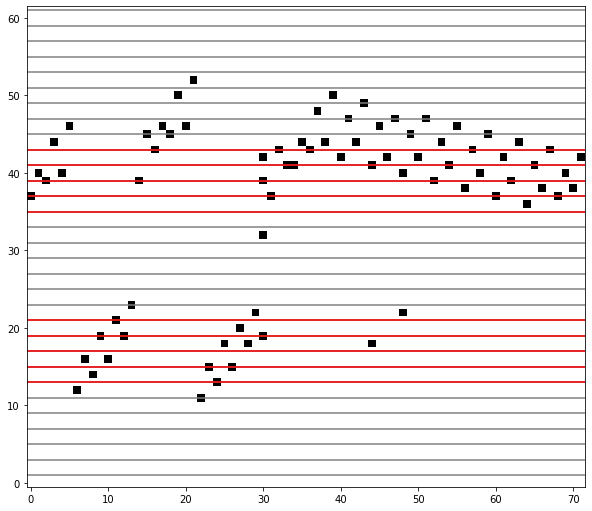

In [161]:
i = 27
visualizeBootlegScore(X_train[i])

In [162]:
pageinfo_train[i]

('score_feat/Schubert/08929/',
 (1.1984732824427482, 1, 52),
 (1.4694656488549618, 1, 123))

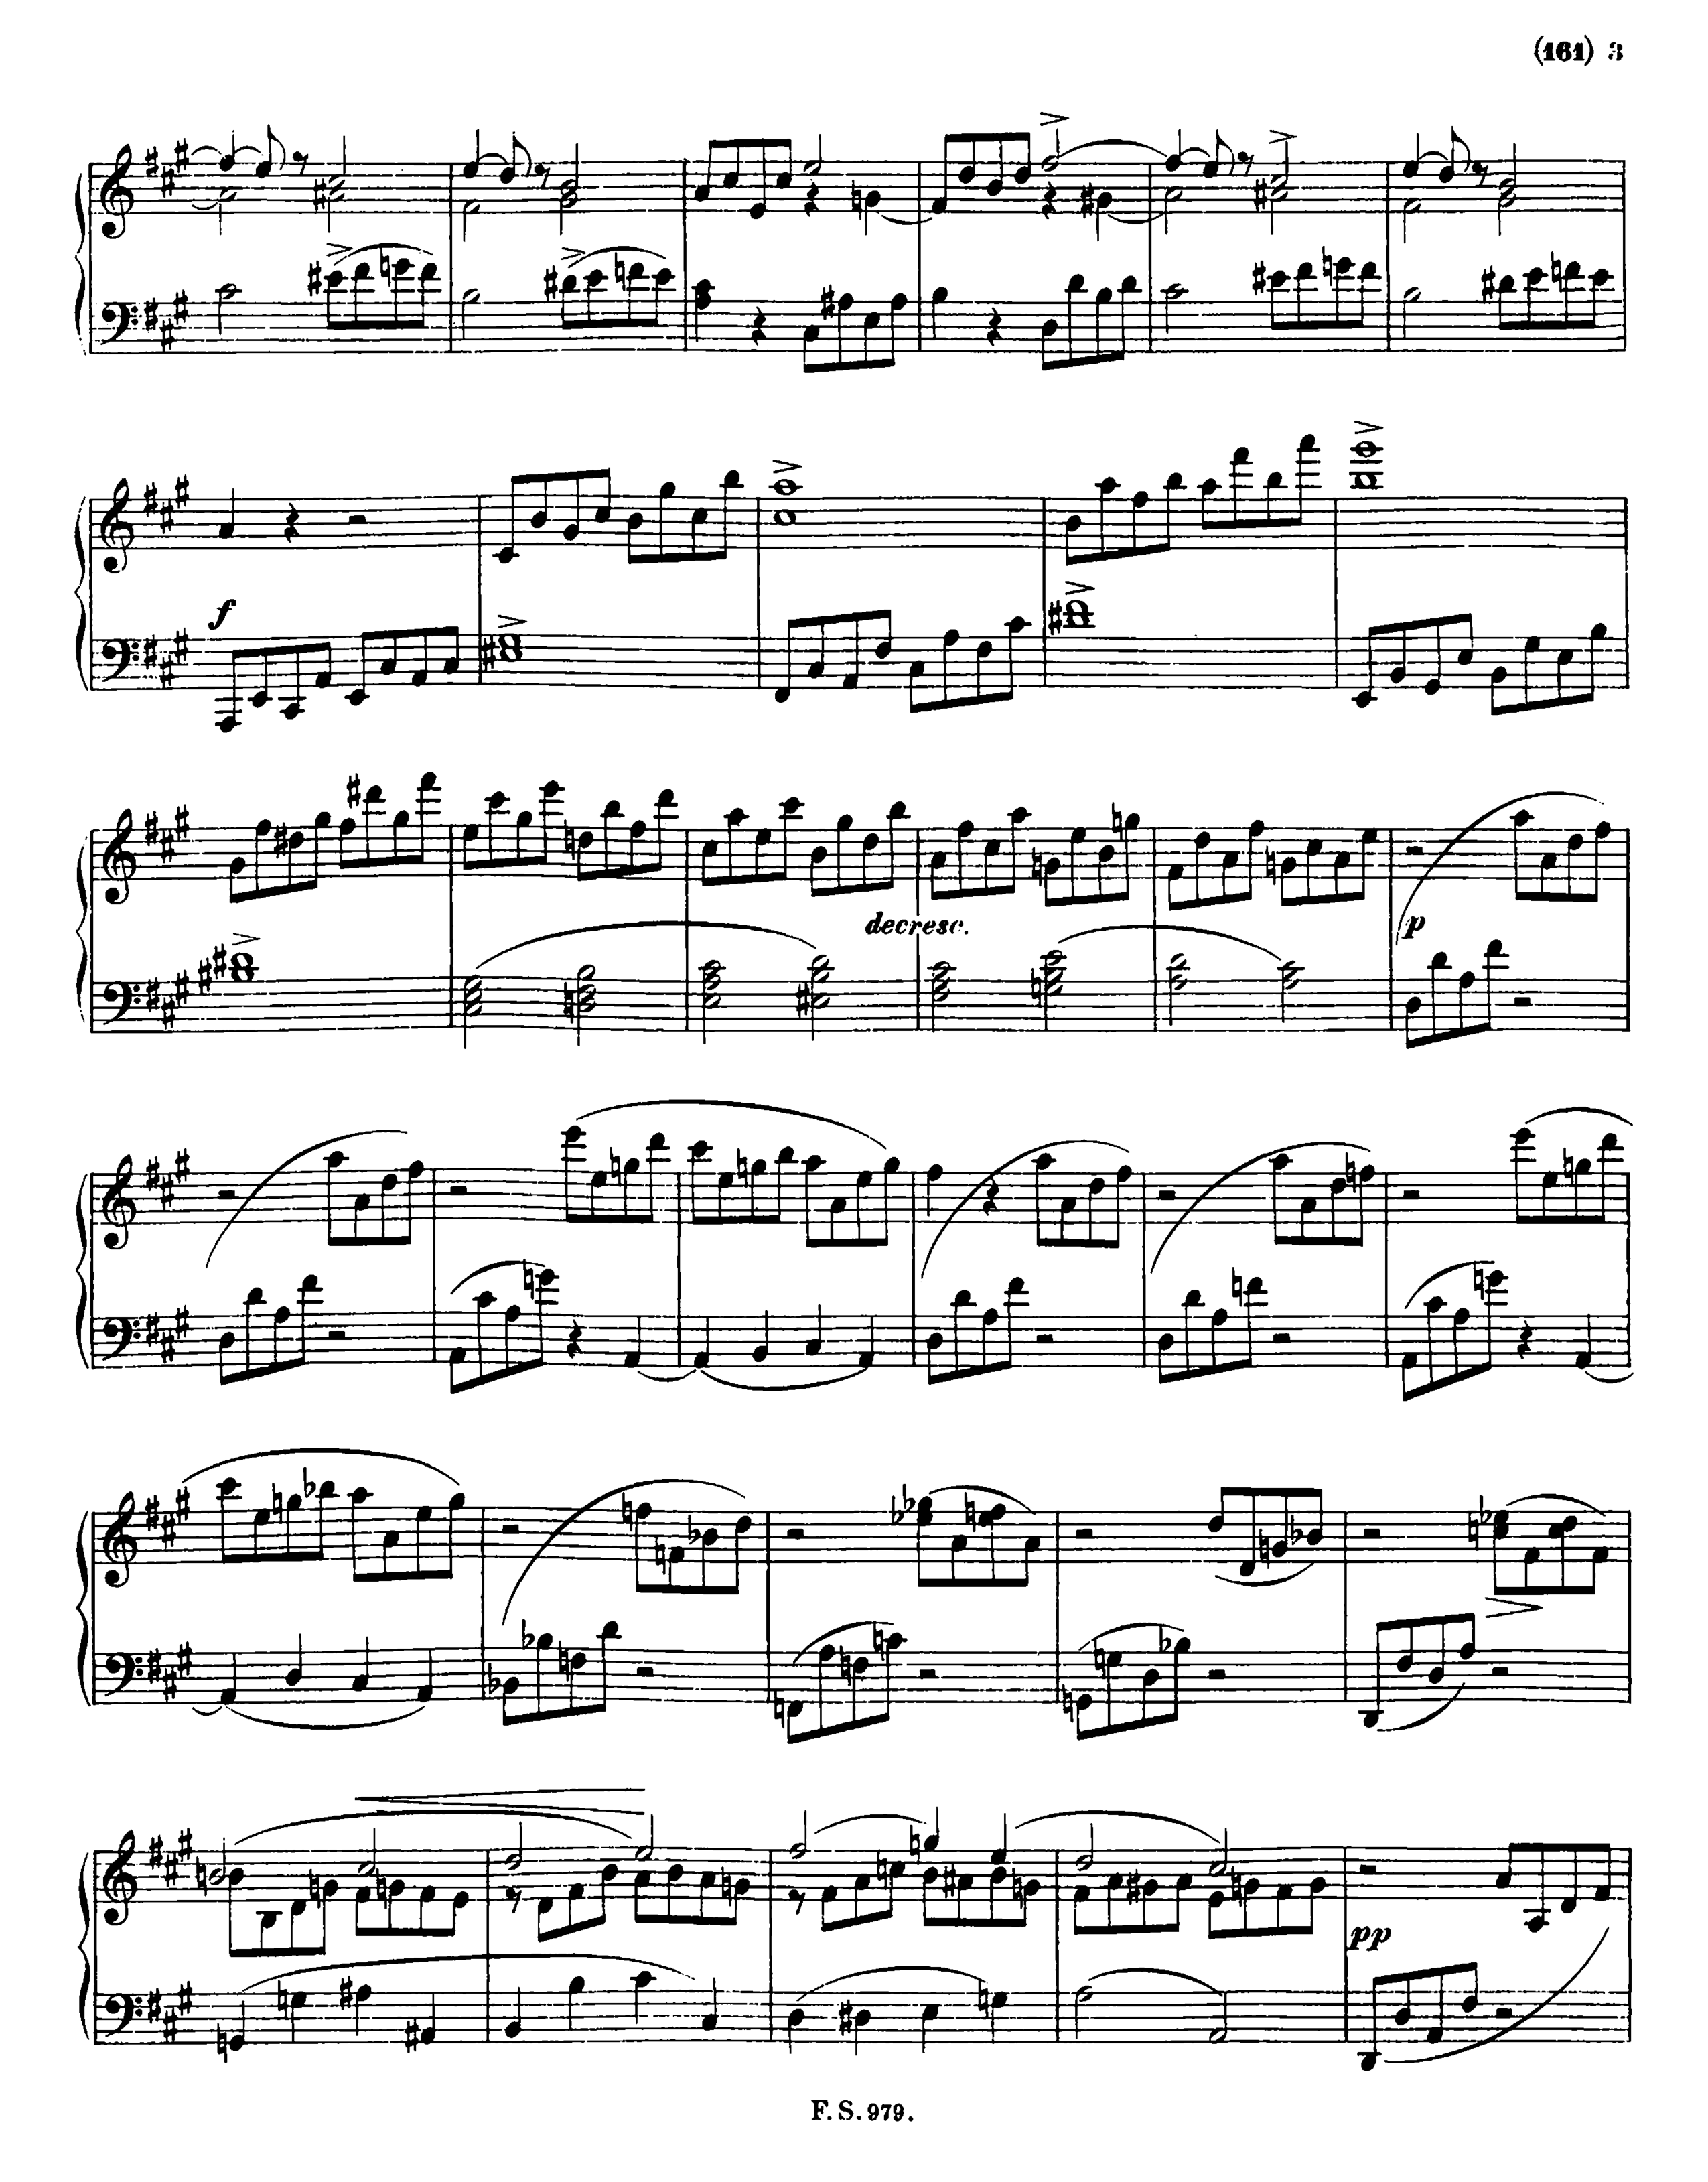

In [163]:
im = getCorrespondingImage(pageinfo_train[i], showNext = False)
im